In [1]:
import numpy as np
import pandas as pd
from utils import Options
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_glass_brain
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
import nibabel as nb
import os
from glob import glob
import matplotlib.pyplot as plt

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/home/predatt/giaald/nipype/nipype/utils/misc.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterator
/home/predatt/giaald/nipype/nipype/interfaces/base/traits_extension.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.

241001-12:13:14,996 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.0-dev+g804adc0


In [2]:
all_maps = sorted(glob('../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-500_nothresh/*.nii'))
to_exclude = [6]
to_exclude = [f'sub-{s:03d}' for s in to_exclude]
all_maps = [s for s in all_maps if os.path.basename(s).split('_')[0] not in to_exclude and 'allruns' in s]
exp_maps = [m for m in all_maps if 'unexp' not in m]
unexp_maps = [m for m in all_maps if 'unexp' in m]

In [3]:
allexp = []
allunexp = []
alldiffs = []
for em, um in zip(exp_maps, unexp_maps):
    thisexp = nb.load(em).get_fdata()[:,:,:,np.newaxis]
    allexp.append(thisexp)
    thisunexp = nb.load(um).get_fdata()[:,:,:,np.newaxis]
    allunexp.append(thisunexp)
    alldiffs.append(thisexp - thisunexp)
allexp = np.concatenate(allexp, axis=3)
allunexp = np.concatenate(allunexp, axis=3)
alldiffs = np.concatenate(alldiffs, axis=3)
meanexp = np.mean(allexp, axis=3)
meanexp = new_img_like(exp_maps[0], meanexp)
meanunexp = np.mean(allunexp, axis=3)
meanunexp = new_img_like(exp_maps[0], meanunexp)
meandiff = np.mean(alldiffs, axis=3)
meandiff = new_img_like(exp_maps[0], meandiff)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


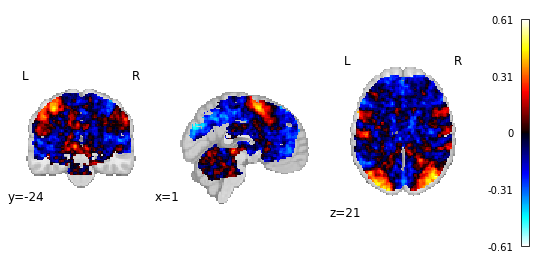

In [4]:
_ = plot_stat_map(meanexp, draw_cross=False)

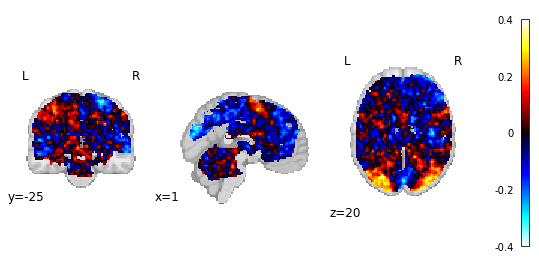

In [5]:
_ = plot_stat_map(meanunexp, draw_cross=False)

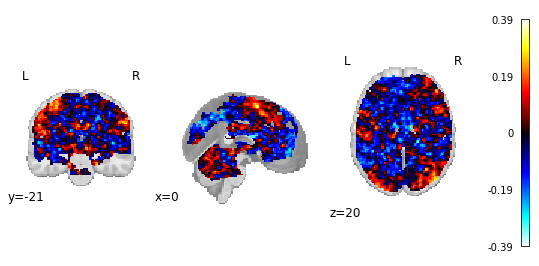

In [24]:
_ = plot_stat_map(meandiff, draw_cross=False)

In [6]:
n_subjects = len(exp_maps)
subject = [f'sub-{i:03d}' for i in range(1, 36)]
subject = [s for s in subject if s not in to_exclude]
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["expected vs unexpected"] + subject,
)

In [26]:
paired_design_matrix

,expected vs unexpected,sub-001,sub-002,sub-003,sub-004,sub-005,sub-007,sub-008,sub-009,sub-010,...,sub-026,sub-027,sub-028,sub-029,sub-030,sub-031,sub-032,sub-033,sub-034,sub-035
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
65,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
second_level_model_paired = SecondLevelModel().fit(
    exp_maps+unexp_maps, design_matrix=paired_design_matrix
)

In [28]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "expected vs unexpected", output_type="all"
)

In [29]:
thresholded_map, threshold = threshold_stats_img(
    stat_maps_paired["z_score"],
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)

In [14]:
positive_map = thresholded_map.get_fdata()
positive_map = new_img_like(thresholded_map, positive_map*(positive_map>0.))
negative_map = thresholded_map.get_fdata()
negative_map = new_img_like(thresholded_map, negative_map*(negative_map<0.))

In [15]:
positive_map = thresholded_map.get_fdata()
positive_map[positive_map>0.].shape

(91,)

In [16]:
negative_map = thresholded_map.get_fdata()
np.max(negative_map[negative_map<0.])

ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
#nb.save(positive_map, 'results_plots/univar_maps/infocoupling_pos.nii')
#nb.save(negative_map, 'results_plots/univar_maps/infocoupling_neg.nii')

In [16]:
threshold

3.2905267314918945

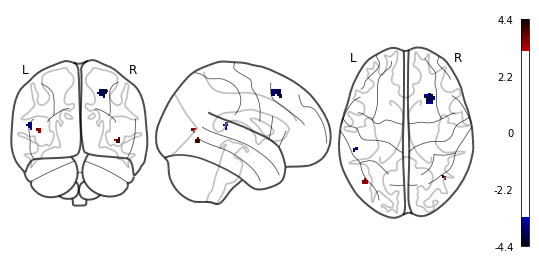

In [30]:
disp=plot_glass_brain(
    thresholded_map,
    threshold=threshold,
    colorbar=True,
    draw_cross=True,
    plot_abs=False
)
#plt.savefig('results_plots/infocoupling.pdf')
# disp.add_contours('../../anat_roi_masks/glasser-v5.nii', linewidths=1.6, levels=[0.3], colors=['blue'])
# disp.add_contours('../../anat_roi_masks/glasser-MST.nii', linewidths=1.6, levels=[0.3], colors=['red'])
# disp.add_contours('../../anat_roi_masks/glasser-LO1.nii', linewidths=1.6, levels=[0.3], colors=['green'])
# disp.add_contours('../../anat_roi_masks/glasser-LO2.nii', linewidths=1.6, levels=[0.3], colors=['green'])

In [18]:
get_clusters_table(stat_maps_paired['z_score'], threshold,
                   cluster_threshold=10, two_sided=True)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.2905267314918945
  warnings.warn(


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,26.0,24.0,46.0,-4.583561,680
1,1a,24.0,32.0,46.0,-4.210165,
2,1b,26.0,24.0,52.0,-4.088958,
3,1c,22.0,16.0,52.0,-3.762844,
4,2,-54.0,-34.0,14.0,-3.843878,96


In [ ]:
ba1937_L_mask = nb.load('../../anat_roi_masks/ba-19-37_L.nii').get_fdata()
ba1937_R_mask = nb.load('../../anat_roi_masks/ba-19-37_R.nii').get_fdata()
ba4_L_mask = nb.load('../../anat_roi_masks/ba-4_L.nii').get_fdata()
ba8_R_mask = nb.load('../../anat_roi_masks/ba-8_R.nii').get_fdata()

In [ ]:
np.clip(thresholded_map.get_fdata(), 0, 1).sum()

In [ ]:
binmask = new_img_like('../../anat_roi_masks/ba-19-37.nii', np.clip(np.abs(thresholded_map.get_fdata()), 0, 1))

In [ ]:
#nb.save(binmask, '/project/3018040.07/anat_roi_masks/ba-19-37-infocoupling.nii')

In [ ]:
disp=plot_glass_brain(binmask)
disp.add_contours('../../anat_roi_masks/ba-19-37.nii', linewidths=1.6, levels=[0.3], colors=['blue'])

In [ ]:
sorted(glob('../../anat_roi_masks/*'))

In [ ]:
threshold1

In [ ]:
expmap.shape

In [ ]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_exp.nii', threshold=0.8)

In [ ]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_unexp.nii', threshold=0.7)

In [ ]:
tc = pd.read_csv('infocoupling/FIR_timecourses/sub-001_ba-17-18_contr-objscrvsbas_top-500.csv')
n_timepoints = tc.delay.nunique()
tc = tc.groupby(['delay', 'expected']).mean().reset_index()

In [ ]:
tc.testmodel.unique()

In [ ]:
opt = Options(
    sub='sub-001',
    task='test',
    model=27
)

In [ ]:
wholebrainDS = load_betas(opt, mask_templ=None, fir=True)

In [ ]:
wholebrainDS.a.voxel_dim

In [ ]:
wholebrainDS.fa.voxel_indices.shape

In [ ]:
np.max(wholebrainDS.fa.voxel_indices, axis=0)

In [ ]:
n_voxels = wholebrainDS.samples.shape[1]
wholebrainDS = split_expunexp(wholebrainDS)
nanmask = np.all(np.isfinite(wholebrainDS.samples), axis=0)
wholebrainDS = wholebrainDS[:, nanmask]

In [ ]:
wholebrainDS.samples.shape

In [ ]:
univar_df = pd.DataFrame(
        {'delay': wholebrainDS.sa.delay,
         'expected': wholebrainDS.sa.expected,
         'samples': list(wholebrainDS.samples)}
    )
univar_df = univar_df.groupby(['delay', 'expected']).mean().reset_index()

In [ ]:
# Get (n. voxels x n. timepoints) arrays for exp and unexp
exp_univar_array = np.vstack(univar_df[univar_df.expected==1].samples).T
unexp_univar_array = np.vstack(univar_df[univar_df.expected==0].samples).T
# Normalize
exp_univar_array = (exp_univar_array - np.mean(exp_univar_array, axis=1, keepdims=True))/np.std(exp_univar_array, axis=1, keepdims=True)
unexp_univar_array = (unexp_univar_array - np.mean(unexp_univar_array, axis=1, keepdims=True))/np.std(unexp_univar_array, axis=1, keepdims=True)

In [ ]:
# Same thing for multivariate sequence
exp_multivar_array = np.hstack(tc[tc.expected==True].distance).reshape(1, n_timepoints)
unexp_multivar_array = np.hstack(tc[tc.expected==False].distance).reshape(1, n_timepoints)
exp_multivar_array = (exp_multivar_array - np.mean(exp_multivar_array, axis=1, keepdims=True))/np.std(exp_multivar_array, axis=1, keepdims=True)
unexp_multivar_array = (unexp_multivar_array - np.mean(unexp_multivar_array, axis=1, keepdims=True))/np.std(unexp_multivar_array, axis=1, keepdims=True)

In [ ]:
# Compute Pearsons correlations
exp_corrs = np.dot(exp_univar_array, exp_multivar_array.T)/(n_timepoints-1)
unexp_corrs = np.dot(unexp_univar_array, unexp_multivar_array.T)/(n_timepoints-1)

In [ ]:
# Convert into brain maps
i, j, k = wholebrainDS.fa.voxel_indices.T

exp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
exp_map[i, j, k] = exp_corrs.flatten()
exp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', exp_map)

unexp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
unexp_map[i, j, k] = unexp_corrs.flatten()
unexp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', unexp_map)

In [ ]:
plot_stat_map(exp_map)

In [ ]:
plot_stat_map(unexp_map)

In [ ]:
nb.save(exp_map, 'exp_map.nii')

In [ ]:
plot_stat_map('exp_map.nii')